# Introduction

L'objectif du notebook est de concevoir un premier modèle de classification d'images. On va utliser une architecture lenet pour commencer. C'est CNN simple qui va nous permettre de nous faire une première idée de la contribution des différents facteurs (data, hyper-paramètres) à la performance de notre modèle.

Nos ressources de calul (et de temps) étant limitées, on va mener les comparaisons de la section 1 (surtout) et 2 sur un sous-ensemble des données,un nombre d'époques limitées et certains hyperparamètres restreints.

On va adopter la stratégie suivante:

1. Tenter d'abord de mesurer l'impact des différentes étapes de pre-processing sur nos modèles. Toutes choses égales par ailleurs, on va tester le même modèle avec dans l'ordre:
  1. Le dataset sans ré-équilibrage de classes et avec les images non zoomées
  2. Le dataset sans ré-équilibrage de classes et avec les images zoomées
  3. Le dataset avec ré-équilibrage de classes et avec les images zoomées
2. Enfin, après avoir trouvé le dataset le plus approprié, on va tester l'impact de différents hyper-paramètres sur la performance
3. On va séléctionner les hyper-paramètres les plus prometteurs de la section 2 et entrainer le modèle de façon plus poussée sur un dataset complet et en restaurant les hyper-paramètres qu'on avait restreints par soucis d'économie de temps lors de nos comparaisons



# Initialisation

In [430]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

[Errno 2] No such file or directory: 'drive/MyDrive/nov23_bds_rakuten'
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


In [431]:
random_state = 42
output_dir = "output/data-modeling-images-1"

In [432]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model

random_state = 42
output_dir = "output/data-modeling-images-1"

# Librarie de fonctions

Bien que je préfère en général définir les fonctions au fur et à mesure de leur utilisation, la multiplication des stratégies que nous allons tester rend plus simple de les rassembler dans cette sections. En les extrayant du déroulement de chaque stratégie, nous pourrons plus efficacement dpuliquer et identifier leur trame commune.

## Import des données

Commençons par définir une fonction **import_images** qui permet d'importer le set d'images qu'on souhaite utiliser

In [433]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

## Rapport des modéles

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes statégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses resultats:
* Un nom et un id de modèle
* les sources de données utlisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* L'état en cours de l'entrainement ainsi que nombre d'éqoques à atteindre
* Les métriques de performance de l'entrainement, la validation et des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arretés en cas d'interruption. Dans ce cas, on veillera également à sauvegarder l'état des modèles ayant la meilleurs performance, afin de compléter l'entrainement sur les époques manquantes.

Plus tard, le fichier **model_reporting.csv** nous servira aussi à comparer les modéles de chaque notebook de modélisation. Pour cette raison, on va tenter d'être le plus complet possible dans les informations qu'on y met.

Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèles d'exemple

In [434]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "train_size": int(42458),

      #hyper parameters
      "image_size": int(300),
      "image_color_rgb": True,
      "batch_size":int(32),
      "image_data_generator_params": {"rescale":1./255,"shear_range":0.2,"zoom_range":0.2,"horizontal_flip":True},
      "start_lr": 0.001,
      "last_lr": 0.0001,
      "optimizer": "adam",

      #fit info
      "target_epochs": int(10),
      "last_epoch": int(6),
      "fit_complete": True,

      #metrics
      "f1_score": 0.42,
      "val_f1_score": 0.37,
      "test_f1_score": 0.35,
      "accuracy": 0.57,
      "val_accuracy": 0.39,
      "test_accuracy": 0.41,
      "loss": 1.567,
      "val_loss": 2.657,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe

In [435]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**

In [436]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption

In [437]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle

In [438]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Création du modèle

Ajoutons une fonction **build_model** qui va nous permettre de créer les différentes couches de notre architecture lenet.

In [439]:
def build_model(input_shape):
    model = Sequential()

    model.add(Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))

    model.add(Dense(27, activation='softmax'))

    return model

Nous allons également avoir besoin d'un metric personnalisé **w_f1_score** qui permette de calculer le f1_score weighted.
On veille à ajouter l'annotation **@keras.saving.register_keras_serializable** pour que keras ne pose pas de problème lors du chargement du modèle

In [440]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

## Sauvegarde du modèle

Toujours en vue d'être résilient par rapport aux interruptions qui ont lieu régulierement lors de la phase d'entrainement du modèle, créons des fonctions qui vont nous permettre de sauvgarder et restaurer un modèle keras, afin de pouvoir reprendre l'entrainement s'il a été stoppé, ou même d'afficher les metrics d'un modèle dont l'entrainement est complet.

In [441]:
def load_saved_model(model_id):
  model_path = output_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

In [442]:
def save_model(model_id,model):
  path = output_dir+("/model-%d.keras" % model_id)
  print("save model ",model_id,"to ",path)
  model.save(path)

Comme nous allons afficher des graphiques sur l'évolution des métriques pendant l'entrainement, il nous faut également des fonctions qui nous permettent de sauver, charger un historique

In [443]:
def load_training_history(model_id):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  history = None
  if Path(path).exists():
    with open(path, "rb") as file:
      history = pickle.load(file)
  return history

In [444]:
def save_training_history(model_id,history):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  with open(path, "wb") as file:
    pickle.dump(history,file)

Parcequ'un entrainemnt peut être fait en plusieurs fois, nous devons pouvoir concaténer un historique d'entrainement actuel avec le précédent sauvegardé.

In [445]:
def concat_training_histories(prev_history,actual_history):
  full_history = {}
  for key in actual_history:
    full_history[key]=np.concatenate((prev_history[key],actual_history[key]),axis=0)
  return full_history

In [446]:
def get_full_training_history(model_id,training_history):
  if training_history == None:
    history = load_training_history(model_id)
  else:
    prev_history = load_training_history(model_id)
    if prev_history != None:
      history = concat_training_histories(prev_history,training_history.history)
    else:
      history = training_history.history
  return history

## Callbacks pour l'entrainement du modèles

la callback **LogBest** va nous pemettre de sauvegarder l'état de l'entrainement et les métriques du modèle à la fin de chaque époque.

Seules les meilleurs metriques ne sont sauvegardées. Elles correspondent à la meilleure époque du modèle que nous sauvegardons également. Ils sont donc mis à jour au fur et à mesure de l'entrainement

In [447]:
class LogBest(Callback):
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):

        update_reporting_line(self.model_id,{
            'last_epoch': epoch +1, # Epochs are 0-indexed, so we add 1
            'last_lr': float(K.get_value(self.model.optimizer.learning_rate)),
        })

        if float(logs['val_w_f1_score']) <= float(get_reporting_value(self.model_id,"val_f1_score",0.0)):
          return
        print("\nFound better model with val_f1_score=%.2f" % float(logs['val_w_f1_score']))
        update_reporting_line(self.model_id,{
            "f1_score": logs['w_f1_score'],
            "val_f1_score": logs['val_w_f1_score'],
            "accuracy": logs['accuracy'],
            "val_accuracy": logs['val_accuracy'],
            "loss": logs['loss'],
            "val_loss": logs['val_loss'],
        })
        save_model(self.model_id,self.model)


Cette callback nous permet de stopper l'entrainement lorsque le f1 score ne progresse plus.

In [448]:
early_stopping = EarlyStopping(
              monitor='val_w_f1_score',
              mode="max", #stop when f1 score is not increasing anymore
              patience=5,           # Number of epochs with no improvement
              min_delta=1e-2,       # Minimum change to qualify as an improvement
)

## Evaluation du modèle

Ajoutons quelques fonctions qui vont nous faciliter l'affichage de graphiques et de matrices lors de la phase d'évaluation du modèle

La fonction **plot_training_history** permet d'afficher l'évolution des différentes métriques en suivant le cours des époques de la phase d'entrainement

In [449]:
def plot_training_history(history):
  x = range(1,len(history['accuracy']) + 1 )
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(x,history['val_accuracy'],label="val_accuracy")
  plt.plot(x,history['accuracy'],label="accuracy")
  plt.plot(x,history['val_w_f1_score'],label="val_f1_score")
  plt.plot(x,history['w_f1_score'],label="f1_score")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title("Accuracy/f1 evolution during training")
  plt.legend()

  plt.subplot(122)
  plt.plot(x,history['val_loss'],label="val_loss")
  plt.plot(x,history['loss'],label="loss")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss evolution during training")
  plt.legend()

  plt.show()


Enfin ajoutons une fonction **plot_confusion_matrix** qui nous permette d'afficher la matrice de confusion d'une façon qui soit lisible

In [450]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g'
              ,xticklabels=classes_keras,yticklabels=classes_keras)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

# Modélisation 1.1

Pour cette prémière modélisation, on va appliquer la statégie 1.1. C'est à dire tester un modèle simple lenet sur les données sans ré-équilibrage et sans zoom sur les images.

Commençons par initialiser la variable **model_id**
Pour les ids de modèles, on va adopter une convention à trois chiffres:

1.   Le numéro du notebook (ici 1)
2.   Le premier niveau de stratégie (ici 1)
3.   le deuxième niveau de stratégie (ici 1 également)



In [451]:
model_id = 111

## Import des données

On va donc importer les images dans leur version originale (non zoomées)

In [452]:
image_path = import_images("data/images.zip","/tmp/rakuten-images-1")

images already imported from drive


Chargeons maintenant les données du dataset sans ré-échantillonage

In [453]:
df = pd.read_csv("output/data-exploration/X_train_pre.csv")
df.head()

,index,productid,imageid,prdtypecode,text,lang
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr


## Preprocessing

Cette version du dataset ne contenant pas encore la colonne **imagefile** qui va nous être necessaire, ajoutons là

In [454]:
df["imagefile"] = "image_" + df["imageid"].astype("str") + "_product_" + df["productid"].astype("str") + ".jpg"
df.head()

,index,productid,imageid,prdtypecode,text,lang,imagefile
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,image_1263597046_product_3804725264.jpg
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,image_1008141237_product_436067568.jpg
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,image_938777978_product_201115110.jpg
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,image_457047496_product_50418756.jpg
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,image_1077757786_product_278535884.jpg


On souhaiter mener nos test sur avec un ensemble d'entrainement constitué d'environ 50% des données. Ca représente à peu près 42,000 observations. On tentera de conserver le même nombre d'observations pour les ensembles d'entrainement qu'on va utiliser aux différentes étapes de notre stratégie.

On va d'abord constituer un ensemble de test et un ensemble de validaton identiques à ceux généré par le notebook **data_preprocessing_resampling**, ça nous facilitera les comparaisons dans le cadre de notre stratégie.

Créons deux variables **X** et **y** qui vont contenir respectivement, les variables explicatives et la variable cible.

In [455]:
X = df.drop("prdtypecode",axis=1)
y = df["prdtypecode"]

Commençons par scinder les données en un set d’entraînement (**X_train**,**y_train**) et un set de test (**X_test**,**y_test**).

Ce premier ensemble de test comprend 20% des données choisies aléatoirement mais en respectant la répartition initiale des classes. On veille également à toujours passer le même **random_state** pour s'assurer que la fonction renvoie toujours le même résultat si on doit ré-executer ce notebook plus tard.

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state,shuffle=True,stratify=y)

On va maintenant couper en deux l'ensemble de test pour que la moitié de ses données aillent dans un ensemble de validation (**X_val**,**y_val**).

In [457]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state = random_state,shuffle=True,stratify=y_test)

Finalement, on réduit encore l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ.

In [458]:
target_train_size = int(len(X) * 0.10)
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 8491
X_train length is now 8491


## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [459]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [460]:
#test todo: remove
#reporting_df = create_reporting_df()

In [461]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [462]:
add_reporting_line(model_id,"Modèle 1.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [463]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-exploration/X_train_pre.csv",
    "dataset_resampled": False,
    "image_dataset_source" : "data/images.zip",
    "image_dataset_zoomed" : False,
    "train_size": len(X_train),
})

## Générateurs d'images

Dans cette section, nous allons créer les générateurs d'image qui vont fournir au modèle les images.

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [464]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


Pour le genrateur d'entrainement, on va volontairement limiter les transformations appliquées aux images afin de réduire le temps d'entrainement. Rappelons que nous ne sommes pas pour l'instant à la recherche de la meilleur performance. On souhaite juste avoir une base de comparaison solide pour nos différentes startégies.

Pour la même raison, on restreint également la taille des images

In [465]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})
batch_size=32
target_img_size = (128,128,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)





Found 8491 validated image filenames belonging to 27 classes.


In [466]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [467]:
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il ny a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On choisi d'utiliser le taux d'apprentissage par défaut (0.001) pour comparer nos stratégies, toujours dans l'esprit de garde une base de comparaison simple.

In [468]:
model = load_saved_model(model_id)
start_lr = 0.001
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-111.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

On procéde à l'entrainement du modèle uniquement si le rapport nous indique que son entrainement n'est pas fini (colonne **fit_complete**).

Dans le cas de la reprise d'un entrainement interrompu, on reprend l'entrainement pour le nombre d'époques qu'il reste à accomplir pour atteindre le nombre d'époque visée **target_epochs**

Une fois l'entrainement terminé, on passe **fit_complete** à **True**.

Les metriques sur la progression l'entrainement ainsi que les meilleurs modèles sont récoltées et enregistrées dans la callback **LogBest**

In [469]:
target_epochs = 3
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [470]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [471]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 35s 132ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [472]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistrer ces infos dans le rapport.

In [473]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.23
accuracy on test dataset=0.28


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

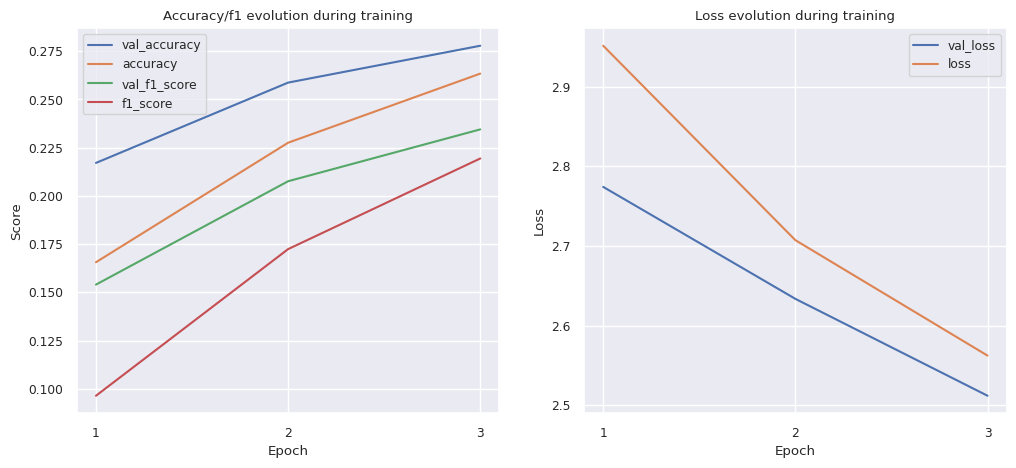

In [474]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [475]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.21      0.41      0.28       311
        1140       0.12      0.09      0.10       267
        1160       0.69      0.46      0.55       396
        1180       0.00      0.00      0.00        76
        1280       0.15      0.11      0.13       487
        1281       0.00      0.00      0.00       207
        1300       0.22      0.31      0.26       505
        1301       0.00      0.00      0.00        81
        1302       0.00      0.00      0.00       249
        1320       0.18      0.03      0.05       324
        1560       0.13      0.03      0.05       507
        1920       0.40      0.55      0.47       431
        1940       0.00      0.00      0.00        81
        2060       0.23      0.31      0.27       499
        2220       0.00      0.00      0.00        82
        2280       0.47      0.30      0.37       476
        2403       0.28      0.46      0.35       477
        2462       0.33    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

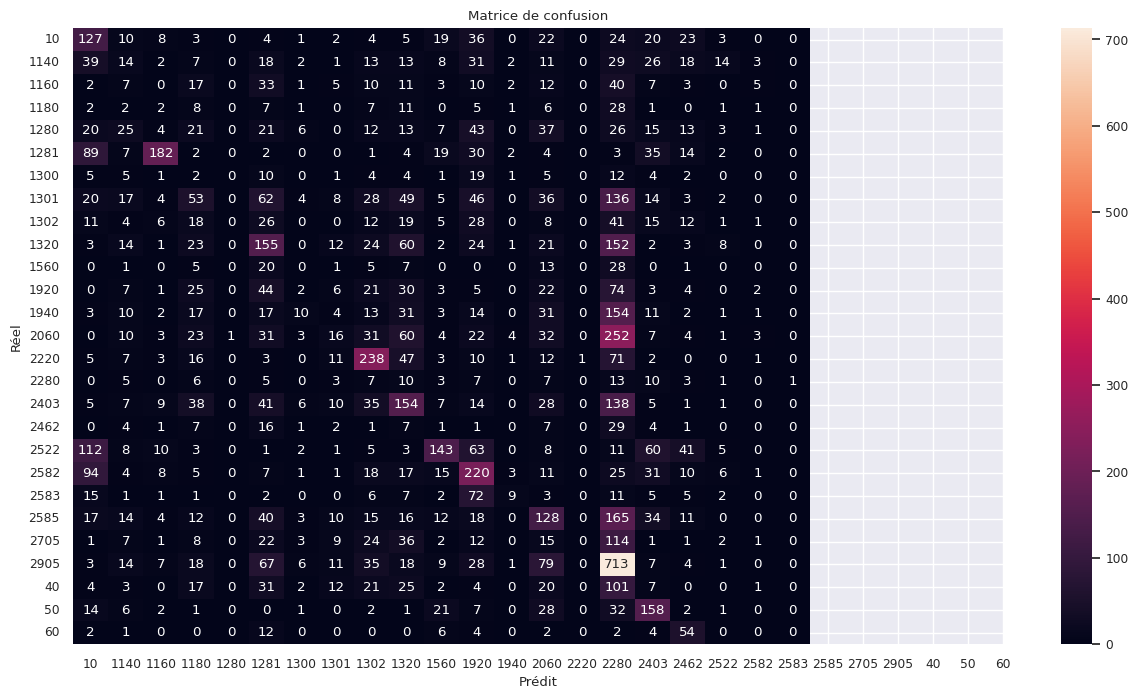

In [476]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [477]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 1.1
dataset_source                           output/data-exploration/X_train_pre.csv
dataset_resampled                                                          False
image_dataset_source                                             data/images.zip
image_dataset_zoomed                                                       False
train_size                                                                8491.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.2

On va maintenant tester les paramètres du même modèles mais en utilisant cette fois les images zoomées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [478]:
model_id = 112

## Import des données

Cette fois-ci, on importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [479]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données modifié par le même notebook. La seule différence par rapport au dataset de la modélisation 1.1, étant l'ajout d'une colonne **imagefile** contenant les chemins relatifs de fichiers.  

In [480]:
df = pd.read_csv("output/data-preprocessing-images/df_pre.csv")
df.head()

,index,productid,imageid,prdtypecode,text,lang,text_fr,imagefile
0,0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...,10/image_1263597046_product_3804725264.jpg
1,1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,2280/image_1008141237_product_436067568.jpg
2,2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,50/image_938777978_product_201115110.jpg
3,3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,Peluche Donald - Europe - Disneyland 2000 (Mar...,1280/image_457047496_product_50418756.jpg
4,4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,La Guerre Des Tuques - Luc a des idées de gran...,2705/image_1077757786_product_278535884.jpg


## Preprocessing

On doit refaire la préparation des ensembles de données d'entrainement, de validation et de test, ayant changé de dataset source.

Malrgé le changement de source de données, la préparation reste identique

Créons deux variables **X** et **y** qui vont contenir respectivement, les variables explicatives et la variable cible.

In [481]:
X = df.drop("prdtypecode",axis=1)
y = df["prdtypecode"]

Commençons par scinder les données en un set d’entraînement (**X_train**,**y_train**) et un set de test (**X_test**,**y_test**).

Ce premier ensemble de test comprend 20% des données choisies aléatoirement mais en respectant la répartition initiale des classes. On veille également à toujours passer le même **random_state** pour s'assurer que la fonction renvoie toujours le même résultat si on doit ré-executer ce notebook plus tard.

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state,shuffle=True,stratify=y)

On va maintenant couper en deux l'ensemble de test pour que la moitié de ses données aillent dans un ensemble de validation (**X_val**,**y_val**).

In [483]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state = random_state,shuffle=True,stratify=y_test)

Finalement, on réduit encore l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ.

In [484]:
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 8491
X_train length is now 8491


## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [485]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [486]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [487]:
add_reporting_line(model_id,"Modèle 1.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [488]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-images/df_pre.zip",
    "dataset_resampled": False,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [489]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [490]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8491 validated image filenames belonging to 27 classes.


In [491]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [492]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il ny a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [493]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-112.keras
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_4 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [494]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [495]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [496]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 34s 127ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [497]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [498]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.20
accuracy on test dataset=0.25


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

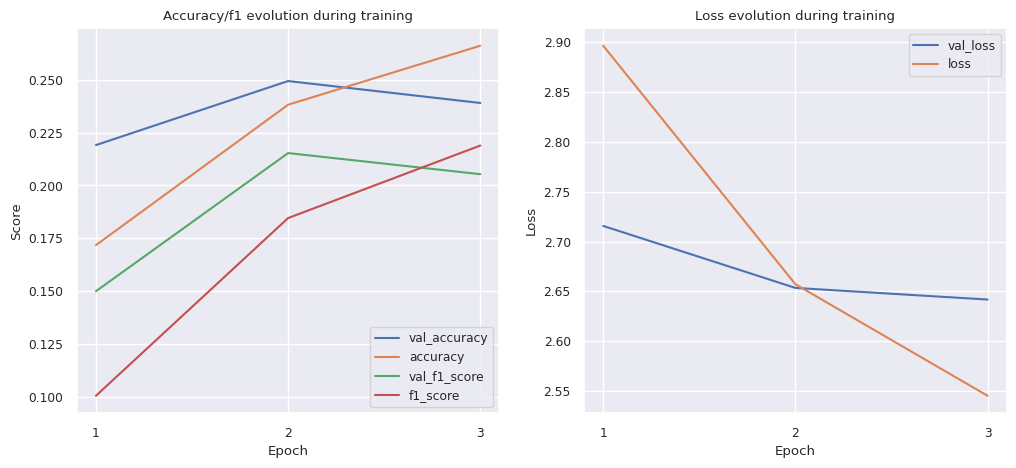

In [499]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [500]:

print(classification_report(y_test.astype("str"),test_pred_class))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.05      0.00      0.01       311
        1140       0.15      0.10      0.12       267
        1160       0.40      0.69      0.51       396
        1180       0.00      0.00      0.00        76
        1280       0.12      0.03      0.04       487
        1281       0.00      0.00      0.00       207
        1300       0.16      0.37      0.23       505
        1301       0.00      0.00      0.00        81
        1302       0.12      0.01      0.02       249
        1320       0.18      0.05      0.07       324
        1560       0.17      0.28      0.21       507
        1920       0.25      0.59      0.35       431
        1940       0.00      0.00      0.00        81
        2060       0.29      0.18      0.22       499
        2220       0.00      0.00      0.00        82
        2280       0.34      0.50      0.41       476
        2403       0.32      0.24      0.28       477
        2462       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

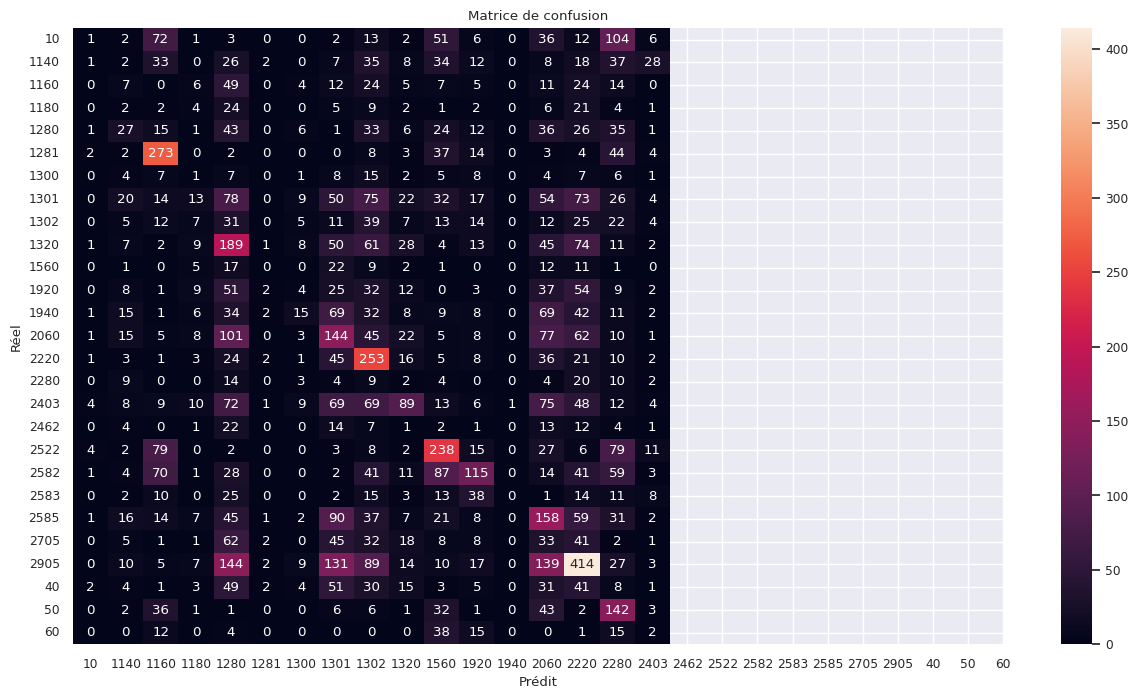

In [501]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [502]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 1.2
dataset_source                       output/data-preprocessing-images/df_pre.zip
dataset_resampled                                                          False
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                                8491.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.3

On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [503]:
model_id = 113

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [504]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [505]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv")
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_train.head()

,Unnamed: 0,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10
2,2,651353882,1033554185,Lecons De Sciences - Cours Superieur - Premier...,fr,Lecons De Sciences - Cours Superieur - Premier...,10/image_1033554185_product_651353882.jpg,10
3,3,4043473264,1306457352,Generations Of Women Historians -,en,Générations de femmes historiens -,10/image_1306457352_product_4043473264.jpg,10
4,4,679913105,1034656535,Oeuvres Dramatiques De F. Schiller Tome 6 -,fr,Oeuvres Dramatiques De F. Schiller Tome 6 -,10/image_1034656535_product_679913105.jpg,10


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [506]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [507]:
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 8491
X_train length is now 8491


Confirmons que les classes sont toujours équilibrées après la réduction.

In [508]:
y_train.value_counts()

1320    315
2060    315
1560    315
1302    315
1281    315
1300    315
40      315
1140    315
1160    315
2522    315
10      315
2220    315
2585    315
2280    314
1280    314
1920    314
1180    314
50      314
2582    314
1940    314
60      314
2583    314
1301    314
2403    314
2905    314
2462    314
2705    314
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [509]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [510]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [511]:
add_reporting_line(model_id,"Modèle 1.3")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [512]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [513]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [514]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8491 validated image filenames belonging to 27 classes.


In [515]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [516]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [517]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-113.keras
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_6 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_7 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [518]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [519]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [520]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 40s 148ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [521]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [522]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.21
accuracy on test dataset=0.23


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

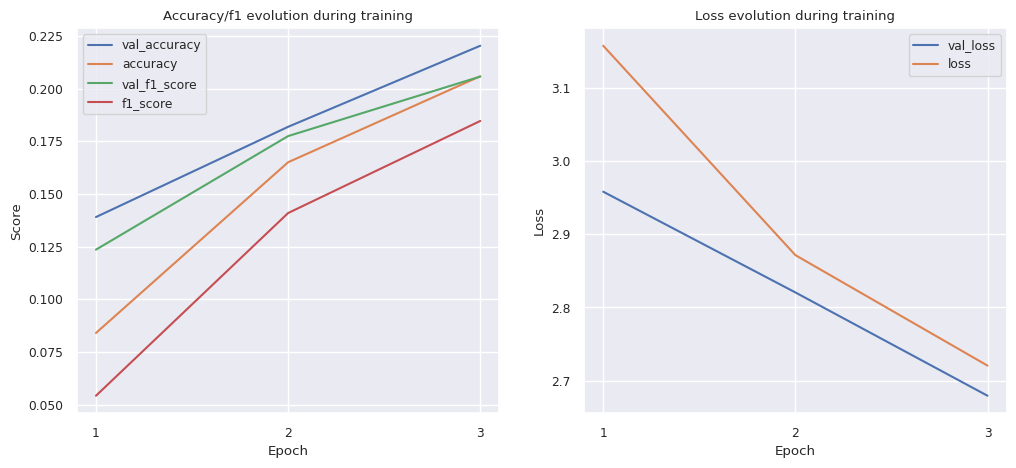

In [523]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [524]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.28      0.16      0.20       311
        1140       0.19      0.06      0.09       267
        1160       0.56      0.67      0.61       396
        1180       0.11      0.04      0.06        76
        1280       0.17      0.00      0.01       487
        1281       0.08      0.02      0.04       207
        1300       0.28      0.07      0.11       505
        1301       0.04      0.05      0.04        81
        1302       0.11      0.05      0.07       249
        1320       0.11      0.37      0.17       324
        1560       0.25      0.06      0.09       507
        1920       0.44      0.52      0.48       431
        1940       0.07      0.21      0.11        81
        2060       0.25      0.30      0.28       499
        2220       0.04      0.13      0.06        82
        2280       0.61      0.09      0.16       476
        2403       0.35      0.17      0.23       477
        2462       0.14    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

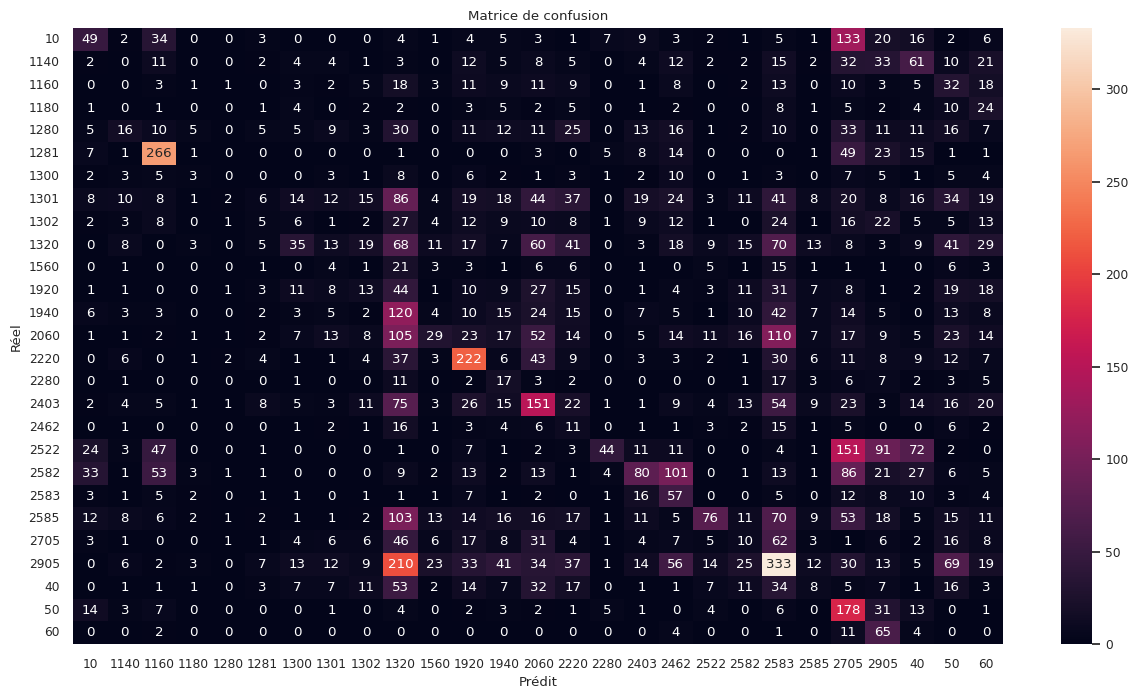

In [525]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [526]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 1.3
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                                8491.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Comparaison des modélisations de la stratégie 1

On va maintenant pouvoir comparer les rapports des 3 modélisations. Affichons leur rapport côte à côte

In [527]:
reporting_df.loc[[111,112,113]].T

model_id,111,112,113
model_name,Modèle 1.1,Modèle 1.2,Modèle 1.3
dataset_source,output/data-exploration/X_train_pre.csv,output/data-preprocessing-images/df_pre.zip,output/data-preprocessing-resampling/df_{train...
dataset_resampled,False,False,True
image_dataset_source,data/images.zip,output/data-preprocessing-images/images_pre.zip,output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed,False,True,True
train_size,8491.0,8491.0,8491.0
image_size,128.0,128.0,128.0
image_color_rgb,True,True,True
batch_size,32.0,32.0,32.0
image_data_generator_params,"{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran..."


todo: comment

# Modélisation 2.1

Maintenant que nous avons identifié le modéles le plus prometteur de la section, nous allons pouvoir tester l'impact de quelques hyper-paramètres sur ses performances.

Commençons par le learning rate. Pour tenter d'accélerer l'apprentissage, nous allons tenter d'augmenter le learning rate de départ. Ensuite nous allons adopter une stratégie de reduction graduelle du learning rate plus communement appelée _Learning rate decay_

Tous les autres paramètres ainsi que le jeu de données seront mantenant constants afin de tenter d'isoler l'impact

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [528]:
model_id = 121

## Import des données

Comme nous ré-utilisons simplement le jeu de données de la modélisaton 1.3, pas besoin de ré-importer les données

## Preprocessing

On va également ré-utiliser les même jeux d'entrainement, de validation et de test

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [529]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [530]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [531]:
add_reporting_line(model_id,"Modèle 2.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [532]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [533]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [534]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8491 validated image filenames belonging to 27 classes.


In [535]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [536]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

On va cette fois-ci changer le taux d'apprentissage de départ. On augmente ce taux d'un facteur 10 pour le passer à *0.01*

In [537]:
start_lr = 0.01
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-121.keras
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_8 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

Crééons une callback qui va nous permettre d'impléementer notre stratégie de _Learning rate decay_

In [538]:
def learning_rate_decay(epoch, lr):
    initial_lr = start_lr
    decay_factor = 0.9
    decay_step = 2

    new_lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return new_lr

lr_scheduler = LearningRateScheduler(learning_rate_decay, verbose=1)

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les paramètres initiaux si ce n'est qu'on passe notre callback **lr_scheduler** au modèle.



In [539]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),lr_scheduler,early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [540]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [541]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 31s 117ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [542]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [543]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.00
accuracy on test dataset=0.05


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

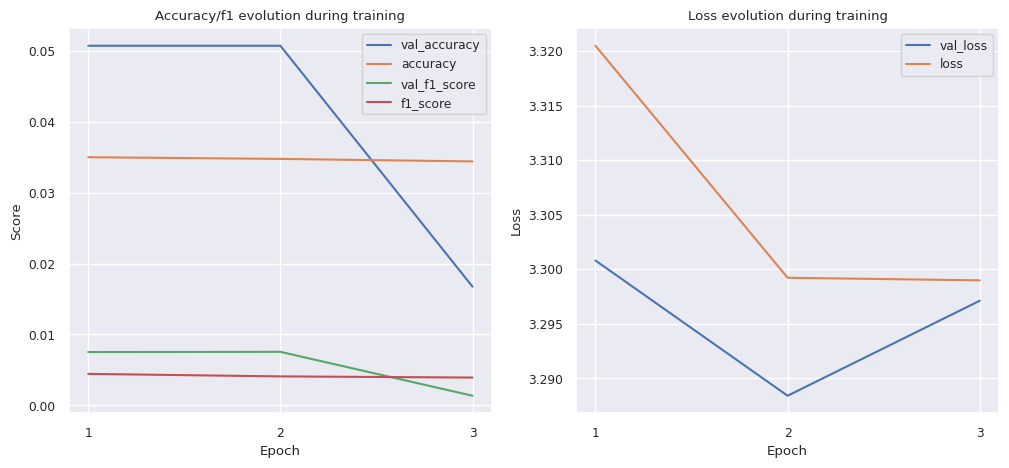

In [544]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [545]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.00      0.00      0.00       311
        1140       0.00      0.00      0.00       267
        1160       0.00      0.00      0.00       396
        1180       0.00      0.00      0.00        76
        1280       0.00      0.00      0.00       487
        1281       0.00      0.00      0.00       207
        1300       0.00      0.00      0.00       505
        1301       0.00      0.00      0.00        81
        1302       0.00      0.00      0.00       249
        1320       0.00      0.00      0.00       324
        1560       0.00      0.00      0.00       507
        1920       0.05      1.00      0.10       431
        1940       0.00      0.00      0.00        81
        2060       0.00      0.00      0.00       499
        2220       0.00      0.00      0.00        82
        2280       0.00      0.00      0.00       476
        2403       0.00      0.00      0.00       477
        2462       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

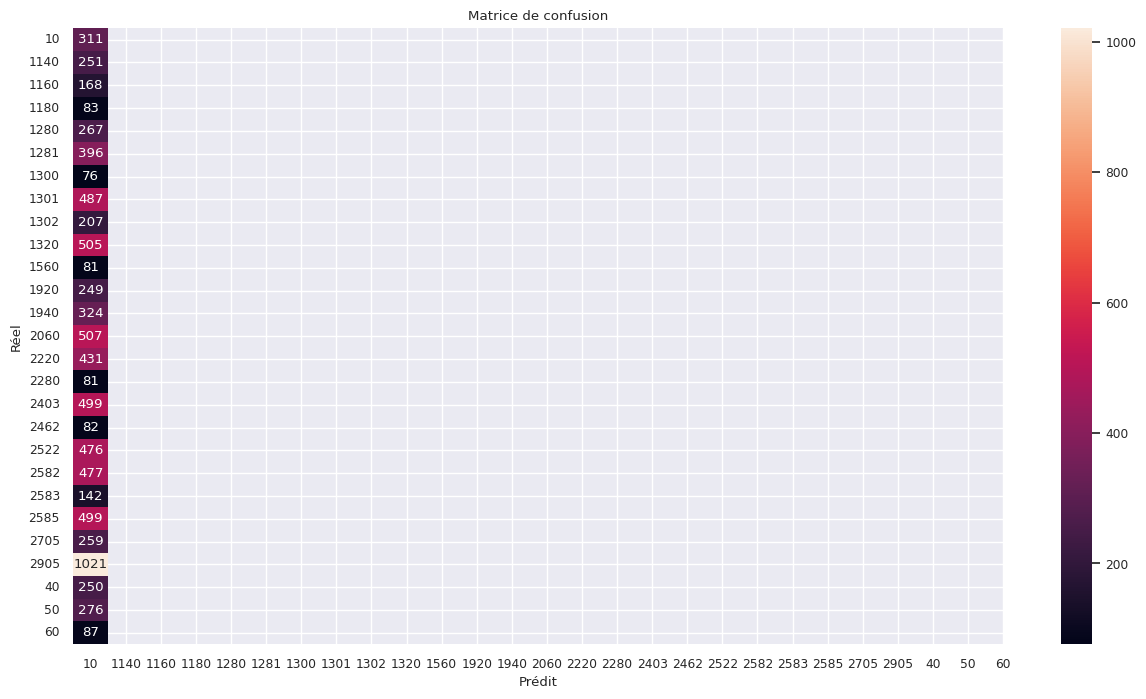

In [546]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [547]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 2.1
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                                8491.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                    0.01
last_lr                                                                     0.01
optimizer                   

2.2

# Modélisation 2.2

Interessons nous maintenant au paramètre batch_size qui régule la taille des données envoyée au modèle à chaque sous-étape d'une époque

Tous les autres paramètres ainsi que le jeu de données seront maintenus constants afin de tenter d'isoler l'impact. Cela signifie que nous allons retaurer **start_lr** à sa valeur initiale et supprimer la stratégie __learning rate decay__

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [548]:
model_id = 122

## Import des données

Comme nous ré-utilisons simplement le jeu de données de la modélisaton 1.3, pas besoin de ré-importer les données

## Preprocessing

On va également ré-utiliser les même jeux d'entrainement, de validation et de test

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [549]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [550]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [551]:
add_reporting_line(model_id,"Modèle 2.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [552]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [553]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On va toutefois doubler **batch_size**

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [554]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 64
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8491 validated image filenames belonging to 27 classes.


In [555]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [556]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

On passe à repasser **start_lr** à **0.001**

In [557]:
start_lr = 0.001
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-1/model-122.keras
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_10 (Aver  (None, 62, 62, 6)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_11 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_11 (Aver  (None, 29, 29, 16)        0         
 agePooling2D)                                                   
                                                                 
 flatten_5 (Flatten)         (None, 13456)             0         
                                                 

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. On veille cette fois à ne pas passer la callback **lr_scheduler** au modèle.



In [558]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [559]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [560]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 29s 219ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [561]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [562]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.21
accuracy on test dataset=0.22


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

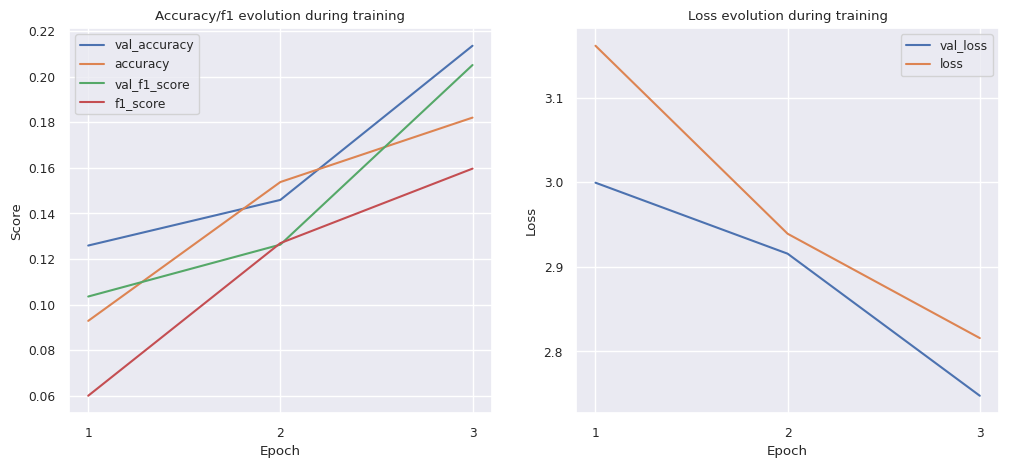

In [563]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [564]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.23      0.18      0.21       311
        1140       0.12      0.23      0.16       267
        1160       0.41      0.71      0.52       396
        1180       0.20      0.05      0.08        76
        1280       0.10      0.05      0.06       487
        1281       0.10      0.08      0.09       207
        1300       0.23      0.19      0.21       505
        1301       0.00      0.00      0.00        81
        1302       0.11      0.03      0.05       249
        1320       0.24      0.07      0.11       324
        1560       0.17      0.18      0.18       507
        1920       0.47      0.47      0.47       431
        1940       0.04      0.20      0.07        81
        2060       0.22      0.12      0.16       499
        2220       0.02      0.04      0.03        82
        2280       0.31      0.27      0.29       476
        2403       0.27      0.11      0.16       477
        2462       0.11    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

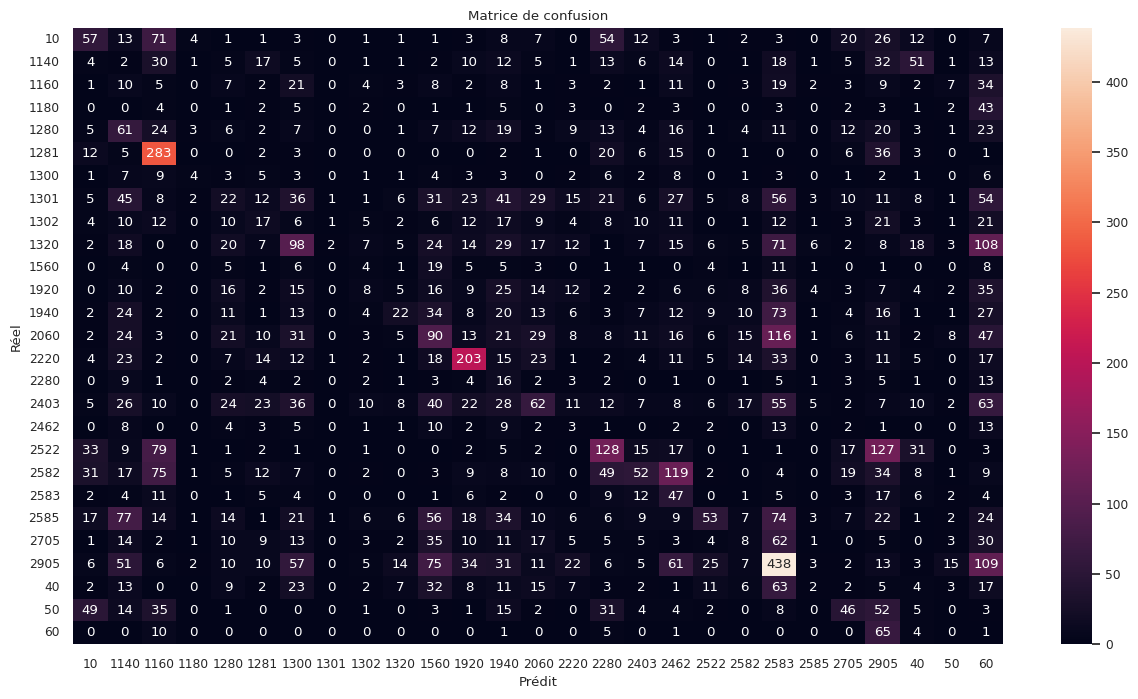

In [565]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [566]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 2.2
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                                8491.0
image_size                                                                 128.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

2.3

# Modélisation 2.3

Interessons nous maintenant à la taille des images. Voyons comment réagi le modèle lorsque nous augmentons celle-ci

Tous les autres paramètres ainsi que le jeu de données seront maintenus constants afin de tenter d'isoler l'impact. Cela signifie que nous allons retaurer **batch_size** à sa valeur initiale

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [567]:
model_id = 123

## Import des données

Comme nous ré-utilisons simplement le jeu de données de la modélisaton 1.3, pas besoin de ré-importer les données

## Preprocessing

On va également ré-utiliser les même jeux d'entrainement, de validation et de test

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [568]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-1/model_reporting.csv


In [569]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
111,Modèle 1.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.219402,0.234481,0.232259,0.263388,0.277830,0.232259,2.562348,2.511956,NaN
112,Modèle 1.2,output/data-preprocessing-images/df_pre.zip,False,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184574,0.215316,0.200091,0.238208,0.249410,0.200091,2.657121,2.653432,NaN
113,Modèle 1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.184613,0.205667,0.206636,0.205816,0.220283,0.206636,2.720563,2.679439,NaN
121,Modèle 2.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,128.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.004094,0.007557,0.004903,0.034756,0.050708,0.004903,3.299227,3.288418,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [570]:
add_reporting_line(model_id,"Modèle 2.3")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [571]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [572]:
classes_keras = list(np.sort(np.array(df["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense à restaurer **batch_size** à sa valeur initiale et à augmenter **target_image_size** à **300**.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [573]:
update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":0.5,
      "width_shift_range":0.05,
      "height_shift_range":0.05,
      "shear_range":0.05,
      "zoom_range":0.05,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 32
target_img_size = (300,300,3)
update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8491 validated image filenames belonging to 27 classes.


In [574]:
validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_val['imagefile'],"prdtypecode": y_val.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [575]:
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.

In [576]:
model = load_saved_model(model_id)
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer="adam",
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

No previous model found at output/data-modeling-images-1/model-123.keras
build model
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 296, 296, 6)       456       
                                                                 
 average_pooling2d_12 (Aver  (None, 148, 148, 6)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 144, 144, 16)      2416      
                                                                 
 average_pooling2d_13 (Aver  (None, 72, 72, 16)        0         
 agePooling2D)                                                   
                                                                 
 flatten_6 (Flatten)         (None, 82944)             0         
                                   

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1.



In [577]:
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/3
265/265 [==============================] - ETA: 0s - loss: 3.2550 - accuracy: 0.0735 - w_f1_score: 0.0470
Found better model with val_f1_score=0.10
save model  123 to  output/data-modeling-images-1/model-123.keras
265/265 [==============================] - 306s 1s/step - loss: 3.2550 - accuracy: 0.0735 - w_f1_score: 0.0470 - val_loss: 3.1229 - val_accuracy: 0.1130 - val_w_f1_score: 0.0966
Epoch 2/3
265/265 [==============================] - ETA: 0s - loss: 2.9932 - accuracy: 0.1409 - w_f1_score: 0.1191
Found better model with val_f1_score=0.16
save model  123 to  output/data-modeling-images-1/model-123.keras
265/265 [==============================] - 270s 1s/step - loss: 2.9932 - accuracy: 0.1409 - w_f1_score: 0.1191 - val_loss: 2.9358 - val_accuracy: 0.1653 - val_w_f1_score: 0.1612
Epoch 3/3
265/265 [==============================] - ETA: 0s - loss: 2.8333 - accuracy: 0.1816 - w_f1_score: 0.1611
Found better model with val_f1_score=0.18
save model  123 to  output/data-modeli

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [578]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-1/model-123.keras


On teste le modèle sur l'ensemble de test

In [579]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 50s 187ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on l'a fourni à keras.

In [580]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [581]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.17
accuracy on test dataset=0.19


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

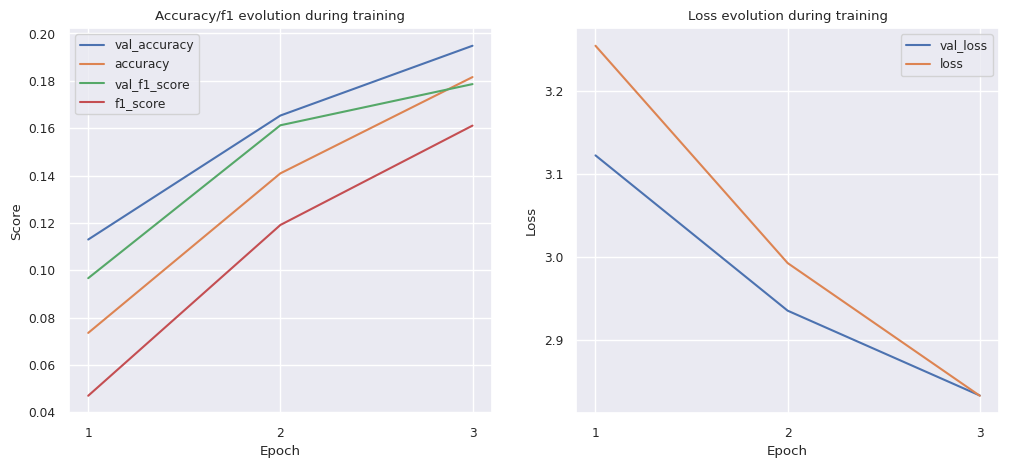

In [582]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [583]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.20      0.23      0.21       311
        1140       0.14      0.08      0.10       267
        1160       0.37      0.73      0.49       396
        1180       0.07      0.04      0.05        76
        1280       0.00      0.00      0.00       487
        1281       0.03      0.02      0.03       207
        1300       0.24      0.10      0.14       505
        1301       0.04      0.01      0.02        81
        1302       0.13      0.03      0.05       249
        1320       0.13      0.15      0.14       324
        1560       0.17      0.30      0.22       507
        1920       0.35      0.45      0.39       431
        1940       0.04      0.12      0.06        81
        2060       0.21      0.17      0.19       499
        2220       0.03      0.10      0.04        82
        2280       0.22      0.45      0.30       476
        2403       0.27      0.18      0.21       477
        2462       0.12    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

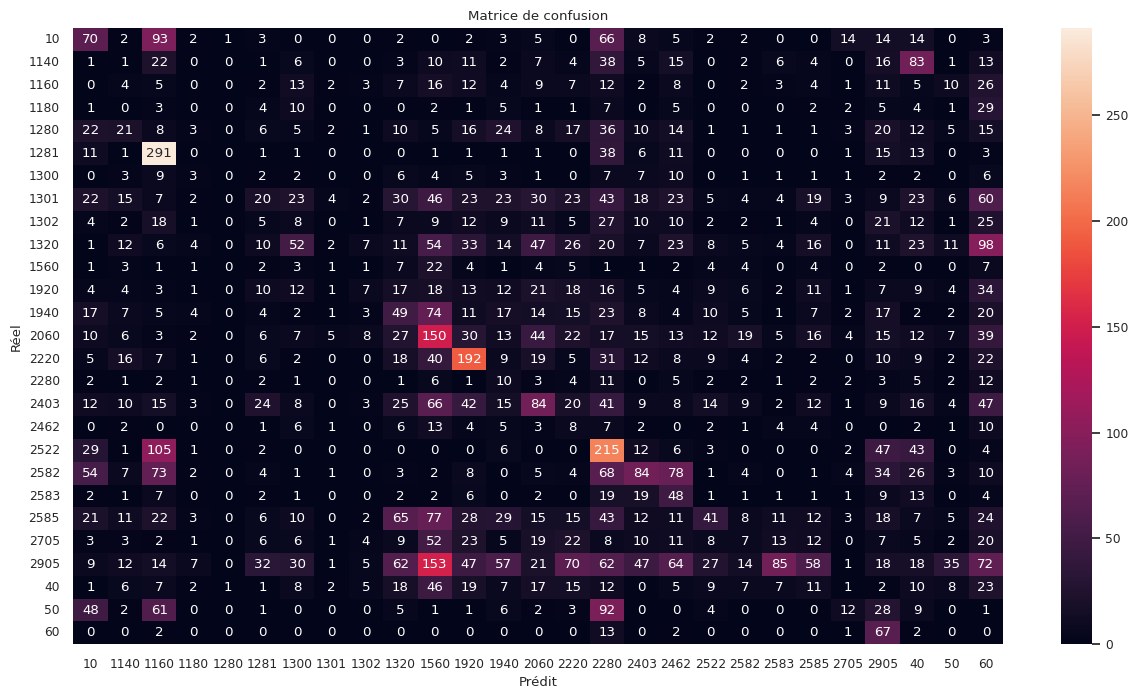

In [584]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [585]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 2.3
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                                8491.0
image_size                                                                 300.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Comparaisons des modélisations de la stratégie 2

On va maintenant pouvoir comparer les rapports des 3 modélisations de cette deuxième section. Affichons leur rapport côte à côte

In [586]:
reporting_df.loc[[121,122,123]].T

model_id,121,122,123
model_name,Modèle 2.1,Modèle 2.2,Modèle 2.3
dataset_source,output/data-preprocessing-resampling/df_{train...,output/data-preprocessing-resampling/df_{train...,output/data-preprocessing-resampling/df_{train...
dataset_resampled,True,True,True
image_dataset_source,output/data-preprocessing-images/images_pre.zip,output/data-preprocessing-images/images_pre.zip,output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed,True,True,True
train_size,8491.0,8491.0,8491.0
image_size,128.0,128.0,300.0
image_color_rgb,True,True,True
batch_size,32.0,64.0,32.0
image_data_generator_params,"{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran..."
